# 作业二：文本分类 Part2（1）

* 本次作业使用神经网络进行文本情感分类
* 使用Stanford-Sentiment-Treebank电影评论作为数据集

文件名|说明
:-:|:-:
senti.train.tsv | 训练数据
senti.dev.tsv | 验证数据
senti.test.tsv | 测试数据

* 文件的每一行是一个句子，和该句子的情感分类，中间由tab分割

**首先导入这次作业需要的包，并设置随机种子**

In [41]:
%matplotlib inline

import math
import random
from collections import defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_random_seed(2020)
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

**设定计算设备与数据集路径**

In [42]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
data_path = Path('/media/bnu/data/nlp-practice/sentiment-analysis/standford-sentiment-treebank')

print('PyTorch Version:', torch.__version__)
print('-' * 60)
if torch.cuda.is_available():
    print('CUDA Device Count:', torch.cuda.device_count())
    print('CUDA Device Name:')
    for i in range(torch.cuda.device_count()):
        print('\t', torch.cuda.get_device_name(i))
    print('CUDA Current Device Index:', torch.cuda.current_device())
    print('-' * 60)
print('Data Path:', data_path)

PyTorch Version: 1.4.0
------------------------------------------------------------
CUDA Device Count: 2
CUDA Device Name:
	 GeForce RTX 2080 Ti
	 GeForce RTX 2080 Ti
CUDA Current Device Index: 0
------------------------------------------------------------
Data Path: /media/bnu/data/nlp-practice/sentiment-analysis/standford-sentiment-treebank


## 数据处理

### 定义数据集的Dataset

In [43]:
# 定义数据集中每一列的数据类型，用于传换成Tensor
text_field = torchtext.data.Field(sequential=True, batch_first=True, include_lengths=True)
label_field = torchtext.data.LabelField(sequential=False, use_vocab=False, dtype=torch.float)

# 将tsv数据构建为数据集
train_set, valid_set, test_set = torchtext.data.TabularDataset.splits(
    path=data_path,
    train='senti.train.tsv',
    validation='senti.dev.tsv',
    test='senti.test.tsv',
    format='tsv',
    fields=[('text', text_field), ('label', label_field)]
)

# 以训练集数据，构建单词表
text_field.build_vocab(train_set)

**简单测试**

In [44]:
print('Tabular Dataset Example:')
print('Text:', valid_set[10].text)
print('Label:', valid_set[10].label)
print('-' * 60)

print('Vocab: Str -> Index')
print(list(text_field.vocab.stoi.items())[:5])
print('Vocab: Index -> Str')
print(text_field.vocab.itos[:5])
print('Vocab Size:')
print(len(text_field.vocab))

Tabular Dataset Example:
Text: ['The', 'mesmerizing', 'performances', 'of', 'the', 'leads', 'keep', 'the', 'film', 'grounded', 'and', 'keep', 'the', 'audience', 'riveted', '.']
Label: 1
------------------------------------------------------------
Vocab: Str -> Index
[('<unk>', 0), ('<pad>', 1), (',', 2), ('the', 3), ('and', 4)]
Vocab: Index -> Str
['<unk>', '<pad>', ',', 'the', 'and']
Vocab Size:
16284


### 定义数据集的Iterator

In [45]:
train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits(
    datasets=(train_set, valid_set, test_set),
    batch_sizes=(256, 256, 256),
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device,
)

**简单测试**

In [46]:
print('Train Iterator:')
for batch in train_iter:
    print(batch)
    print('-' * 60, '\n')
    break
    
print('Valid Iterator:')
for batch in valid_iter:
    print(batch)
    print('-' * 60, '\n')
    break
    
print('Test Iterator:')
for batch in test_iter:
    print(batch)
    print('-' * 60, '\n')
    break

Train Iterator:

[torchtext.data.batch.Batch of size 256]
	[.text]:('[torch.cuda.LongTensor of size 256x9 (GPU 0)]', '[torch.cuda.LongTensor of size 256 (GPU 0)]')
	[.label]:[torch.cuda.FloatTensor of size 256 (GPU 0)]
------------------------------------------------------------ 

Valid Iterator:

[torchtext.data.batch.Batch of size 256]
	[.text]:('[torch.cuda.LongTensor of size 256x14 (GPU 0)]', '[torch.cuda.LongTensor of size 256 (GPU 0)]')
	[.label]:[torch.cuda.FloatTensor of size 256 (GPU 0)]
------------------------------------------------------------ 

Test Iterator:

[torchtext.data.batch.Batch of size 256]
	[.text]:('[torch.cuda.LongTensor of size 256x9 (GPU 0)]', '[torch.cuda.LongTensor of size 256 (GPU 0)]')
	[.label]:[torch.cuda.FloatTensor of size 256 (GPU 0)]
------------------------------------------------------------ 



## 定义模型

### 简单的Self-Attention模型

* 定义以下基于Self-Attention的模型

$$ a_{ts} = \operatorname{emb}(x_t)^T \operatorname{emb}(x_s)$$

$$ \alpha_{t} \propto \exp(\sum_s a_{ts}) $$

$$ h_{self}=\sum_t \alpha_{t} \operatorname{emb}(x_t) $$

* 该句子为正面情感的概率为:

$$ \sigma(w^Th_{self}) $$

* 可以在模型中加入residual connection，将输入的词向量平均向量加入进去

$$ \sigma(w^T(h_{self}+h_{avg})) $$

In [47]:
class SimpleSelfAttentionModel(nn.Module):
    
    def __init__(self, n_words, n_embed, p_drop, pad_idx, res_conn=False):
        super(SimpleSelfAttentionModel, self).__init__()
        self.res_conn = res_conn
        
        self.embed = nn.Embedding(n_words, n_embed, padding_idx=pad_idx)
        self.linear = nn.Linear(n_embed, 1)
        self.drop = nn.Dropout(p_drop)
        
    def forward(self, inputs, mask):
        # (batch, len, n_embed)
        query = self.drop(self.embed(inputs))
        key = self.drop(self.embed(inputs))
        value = self.drop(self.embed(inputs))

        # (batch, len, 1)
        attn_mask = mask.unsqueeze(2)
        attn_mask = attn_mask * attn_mask.transpose(1, 2)
        
        # (batch, len, len)
        score = torch.bmm(query, key.transpose(1, 2))
        score = score.masked_fill(~attn_mask, -1e9)
        attn = F.softmax(score, dim=-1)
        
        # (batch, n_embed)
        h_self = torch.bmm(attn, value).sum(1).squeeze()

        # 处理residual connection的情况
        if self.res_conn:
            # (batch, len, 1)
            mask = mask.float().unsqueeze(2)
            # (batch, len, n_embed)
            h_avg = query * mask
            # (batch, n_embed)
            h_avg = h_avg.sum(1) / (mask.sum(1) + 1e-5)
            h_self = h_self + h_avg
        
        return self.linear(self.drop(h_self)).squeeze()


**简单测试**

In [48]:
model = SimpleSelfAttentionModel(
    n_words=len(text_field.vocab),
    n_embed=200,
    p_drop=0.2,
    pad_idx=text_field.vocab.stoi['<pad>'],
    res_conn=True,
)
model.to(device)

for batch in train_iter:
    inputs, lengths = batch.text
    mask = (inputs != text_field.vocab.stoi['<pad>'])
    outputs = model(inputs, mask)
    print(outputs.shape)
    break

torch.Size([256])


### 简单的Transformer模型

* 接下来自己编写实现一个简单的Transformer的模型, 参考资料如下：
    * [HuggingFace](https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_bert.py)
    * [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

* 首先我们先来实现其中的输入Embedding部分
* 这一部分包含两个模块：Input Embedding， Positional Encoding
* Input Embedding中将权重乘以$ \sqrt {d_{model}} $
* Positional Encoding按照论文中的公式计算:
$$ PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{model}}) $$
$$ PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{model}}) $$

In [49]:
class InputEmbedding(nn.Module):
    def __init__(self, n_words, d_model):
        super(InputEmbedding, self).__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(n_words, d_model, padding_idx=1)
        
    def forward(self, x):
        # (bs, len, d_model)
        return self.embed(x) * np.sqrt(self.d_model)
    

In [107]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, p_drop=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p_drop)
        
        # 计算位置编码
        pe = torch.zeros(max_len, d_model)
        # (max_len, 1)
        pos = torch.arange(0, max_len).unsqueeze(1)
        # 计算分母，通过先转换为log之后exp获得
        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)        

        # (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        # 这里使用register_buffer，使得pe不会被优化器更新
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # (bs, len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

* 绘图观察一下Positional Encoding的结果

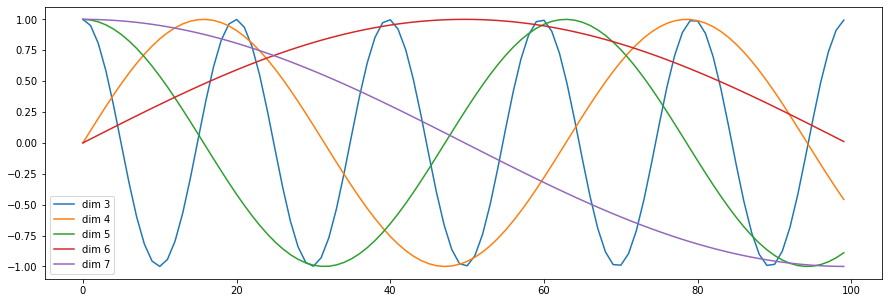

In [108]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(16, p_drop=0)
y = pe.forward(torch.zeros(1, 100, 16))
plt.plot(np.arange(100), y[0, :, 3:8].data.numpy())
plt.legend(["dim %d"%p for p in [3,4,5,6,7]])
plt.show()

* 接下来实现Multi-Head Attention部分
* 对于Attention相关计算公式如下
$$ \operatorname{Attention}(Q,K,V)=\operatorname{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

$$ \operatorname{MultiHead}(Q,K,V)=\operatorname{Concat}(head_1,...,head_h)W^O $$

$$ head_i = \operatorname{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

In [134]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, p_drop=0.1):
        super(MultiHeadAttention, self).__init__()
        # 这里保证head的数量一定要被d_model整除
        assert d_model % n_heads == 0
    
        self.d_model = d_model
        self.n_heads = n_heads
        # 每一个head中Q,K,V的维度
        self.d_hidden = d_model // n_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        
        # 将经过线性变换的数据拆分为多个head
        # (bs, len, n_heads, d_hidden)
        q = self.q_linear(q).view(bs, -1, self.n_heads, self.d_hidden)
        k = self.k_linear(k).view(bs, -1, self.n_heads, self.d_hidden)
        v = self.v_linear(v).view(bs, -1, self.n_heads, self.d_hidden)
        
        # (bs, n_head, len, d_hidden)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # 这里开始计算Attention
        # (bs, n_head, len, len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_hidden)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask==False, -1e9)
        scores = F.softmax(scores, dim=-1)
        # (bs, n_head, len, d_hidden)
        attn = torch.matmul(scores, v)
        
        # (bs, len, d_model)
        concat = attn.transpose(1, 2).reshape(bs, -1, self.d_model)
        concat = self.dropout(concat)
        return self.fc(concat)
        

* 主要的模块已经写好了，这里我们拼装起来

In [141]:
class SimpleTransformerModel(nn.Module):
    def __init__(self, n_words, d_model, n_heads, p_drop=0.1,
                 use_pos=False):
        super(SimpleTransformerModel, self).__init__()
        self.use_pos = use_pos
        
        self.inp_emb = InputEmbedding(n_words, d_model)
        self.pos_enc = PositionalEncoding(d_model, p_drop)
        self.mulattn = MultiHeadAttention(d_model, n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.linear = nn.Linear(d_model, 1)
        
    def forward(self, inputs, mask):
        # (bs, len, d_model)
        x_embed = self.inp_emb(inputs)
        
        if self.use_pos:
            # (bs, len, d_model)
            x_embed = self.pos_enc(x_embed)
        
        # (bs, len, 1)
        attn_mask = mask.unsqueeze(2)

        # (bs, len, len)
        attn_mask = attn_mask * attn_mask.transpose(1, 2)
        # (bs, len, d_model)
        x_attn = self.mulattn(x_embed, x_embed, x_embed, attn_mask)
        
        x_attn = self.norm(x_attn + x_embed)
        
        # (batch, len, 1)
        mask = mask.float().unsqueeze(2)
        # (batch, len, d_model)
        x_attn = x_attn * mask
        # (batch, d_model)
        x_sum = x_attn.sum(1) / (mask.sum(1) + 1e-6)
        return self.linear(x_sum).squeeze()
        

**简单测试**

In [142]:
model = SimpleTransformerModel(
    n_words=len(text_field.vocab),
    d_model=128,
    n_heads=4,
    p_drop=0.2,
)
model.to(device)

for batch in train_iter:
    inputs, lengths = batch.text
    mask = (inputs != text_field.vocab.stoi['<pad>'])
    outputs = model(inputs, mask)
    print(outputs.shape)
    break

torch.Size([256])


### 基于PyTorch的Transformer模型

* 从PyTorch1.2版本开始，PyTorch中也提供了Transformer的实现，这里我们使用一下看看

In [173]:
class PyTorchTransformerModel(nn.Module):
    def __init__(self, n_words, d_model, n_heads, n_layers, p_drop=0.1):
        super(PyTorchTransformerModel, self).__init__()
        self.inp_emb = InputEmbedding(n_words, d_model)
        self.pos_enc = PositionalEncoding(d_model, p_drop)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model, n_heads, 
                dim_feedforward=d_model*2,
                dropout=p_drop
            ),
            num_layers=n_layers,
            norm=nn.LayerNorm(d_model)
        )
        self.linear = nn.Linear(d_model, 1)
        
    def forward(self, inputs, mask):
        # (bs, len, d_model)
        x_embed = self.inp_emb(inputs)
        # (bs, len, d_model)
        x_embed = self.pos_enc(x_embed)
        
        # (len, bs, d_model)
        # 注意src_key_padding_mask参数中 pad的位置为True
        x_enc = self.encoder(x_embed.transpose(0, 1), src_key_padding_mask=~mask)
        x_enc = x_enc.transpose(0, 1)
        
        # (batch, len, 1)
        mask = mask.float().unsqueeze(2)
        # (batch, len, d_model)
        x_enc = x_enc * mask
        # (batch, d_model)
        x_sum = x_enc.sum(1) / (mask.sum(1) + 1e-6)
        return self.linear(x_sum).squeeze()
        
    

**简单测试**

In [174]:
model = PyTorchTransformerModel(
    n_words=len(text_field.vocab),
    d_model=128,
    n_heads=4,
    n_layers=1,
)
model.to(device)

for batch in train_iter:
    inputs, lengths = batch.text
    mask = (inputs != text_field.vocab.stoi['<pad>'])
    outputs = model(inputs, mask)
    print(outputs.shape)
    break

torch.Size([256])


## 模型训练

In [115]:
class TCLearner:
    def __init__(self, model):
        self.model = model
        self.model.to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3)
        self.crirerion = nn.BCEWithLogitsLoss()
    
    def _calc_correct_num(self, outputs, targets):
        preds = torch.round(torch.sigmoid(outputs))
        return (preds == targets).int().sum().item()
    
    def fit(self, train_iter, valid_iter, n_epochs):
        for epoch in range(n_epochs):
            model.train()
            total_loss = 0.0
            total_sents, total_correct = 0, 0
            
            for batch in train_iter:
                inputs, lengths = batch.text
                targets = batch.label
                mask = (inputs != text_field.vocab.stoi['<pad>'])
                
                outputs = self.model(inputs, mask)
                loss = self.crirerion(outputs, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * len(targets)
                total_sents += len(targets)
                total_correct += self._calc_correct_num(outputs, targets)
            
            epoch_loss = total_loss / total_sents
            epoch_acc = total_correct / total_sents
            print(f'Epoch {epoch+1}')
            print(f'Train --> Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.3f}')
            
            model.eval()
            total_loss = 0.0
            total_sents, total_correct = 0, 0
            with torch.no_grad():
                for batch in valid_iter:
                    inputs, lengths = batch.text
                    targets = batch.label
                    mask = (inputs != text_field.vocab.stoi['<pad>'])

                    outputs = self.model(inputs, mask)
                    loss = self.crirerion(outputs, targets)

                    total_loss += loss.item() * len(targets)
                    total_sents += len(targets)
                    total_correct += self._calc_correct_num(outputs, targets)
                
            epoch_loss = total_loss / total_sents
            epoch_acc = total_correct / total_sents
            print(f'Valid --> Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.3f}')
        
    def predict(self, test_iter):
        model.eval()
        total_loss = 0.0
        total_sents, total_correct = 0, 0
        with torch.no_grad():
            for batch in test_iter:
                inputs, lengths = batch.text
                targets = batch.label
                mask = (inputs != text_field.vocab.stoi['<pad>'])

                outputs = self.model(inputs, mask)
                loss = self.crirerion(outputs, targets)

                total_loss += loss.item() * len(targets)
                total_sents += len(targets)
                total_correct += self._calc_correct_num(outputs, targets)

        epoch_loss = total_loss / total_sents
        epoch_acc = total_correct / total_sents
        print(f'Test --> Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.3f}')
        
        

### 简单的Self-Attention模型训练

In [17]:
model = SimpleSelfAttentionModel(
    n_words=len(text_field.vocab),
    n_embed=300,
    p_drop=0.3,
    pad_idx=text_field.vocab.stoi['<pad>'],
    res_conn=False,
)
model.to(device)

learner = TCLearner(model)
learner.fit(train_iter, valid_iter, 10)
learner.predict(test_iter)

Epoch 1
Train --> Loss: 0.723, Acc: 0.613
Valid --> Loss: 0.586, Acc: 0.692
Epoch 2
Train --> Loss: 0.560, Acc: 0.718
Valid --> Loss: 0.528, Acc: 0.751
Epoch 3
Train --> Loss: 0.471, Acc: 0.781
Valid --> Loss: 0.546, Acc: 0.769
Epoch 4
Train --> Loss: 0.418, Acc: 0.815
Valid --> Loss: 0.527, Acc: 0.797
Epoch 5
Train --> Loss: 0.372, Acc: 0.842
Valid --> Loss: 0.565, Acc: 0.804
Epoch 6
Train --> Loss: 0.342, Acc: 0.858
Valid --> Loss: 0.610, Acc: 0.789
Epoch 7
Train --> Loss: 0.321, Acc: 0.869
Valid --> Loss: 0.587, Acc: 0.805
Epoch 8
Train --> Loss: 0.301, Acc: 0.880
Valid --> Loss: 0.628, Acc: 0.807
Epoch 9
Train --> Loss: 0.285, Acc: 0.885
Valid --> Loss: 0.650, Acc: 0.808
Epoch 10
Train --> Loss: 0.275, Acc: 0.892
Valid --> Loss: 0.643, Acc: 0.804
Test --> Loss: 0.498, Acc: 0.824


从上面的结果上来看，相对于Part1在测试集上已经有了一点点的提升

### 简单的Transformer模型训练

In [144]:
model = SimpleTransformerModel(
    n_words=len(text_field.vocab),
    d_model=512,
    n_heads=4,
    p_drop=0.2,
    use_pos=True
)
model.to(device)

learner = TCLearner(model)
learner.fit(train_iter, valid_iter, 25)
learner.predict(test_iter)

Epoch 1
Train --> Loss: 0.633, Acc: 0.645
Valid --> Loss: 0.616, Acc: 0.662
Epoch 2
Train --> Loss: 0.555, Acc: 0.721
Valid --> Loss: 0.590, Acc: 0.682
Epoch 3
Train --> Loss: 0.491, Acc: 0.766
Valid --> Loss: 0.566, Acc: 0.704
Epoch 4
Train --> Loss: 0.444, Acc: 0.793
Valid --> Loss: 0.548, Acc: 0.716
Epoch 5
Train --> Loss: 0.402, Acc: 0.820
Valid --> Loss: 0.522, Acc: 0.759
Epoch 6
Train --> Loss: 0.377, Acc: 0.831
Valid --> Loss: 0.512, Acc: 0.758
Epoch 7
Train --> Loss: 0.349, Acc: 0.847
Valid --> Loss: 0.525, Acc: 0.740
Epoch 8
Train --> Loss: 0.322, Acc: 0.860
Valid --> Loss: 0.514, Acc: 0.744
Epoch 9
Train --> Loss: 0.307, Acc: 0.868
Valid --> Loss: 0.505, Acc: 0.758
Epoch 10
Train --> Loss: 0.289, Acc: 0.877
Valid --> Loss: 0.541, Acc: 0.740
Epoch 11
Train --> Loss: 0.275, Acc: 0.884
Valid --> Loss: 0.532, Acc: 0.757
Epoch 12
Train --> Loss: 0.261, Acc: 0.891
Valid --> Loss: 0.521, Acc: 0.763
Epoch 13
Train --> Loss: 0.255, Acc: 0.892
Valid --> Loss: 0.523, Acc: 0.775
Epoch 14

* 简单看一下结果，发现将模型更改的更为复杂后并未获得准确率的提升
* 详细的对比结果，参见提交文档

### 基于PyTorch的Transformer模型训练

In [179]:
model = PyTorchTransformerModel(
    n_words=len(text_field.vocab),
    d_model=256,
    n_heads=4,
    n_layers=2,
    p_drop=0.2
)
model.to(device)

learner = TCLearner(model)
learner.fit(train_iter, valid_iter, 25)
learner.predict(test_iter)

Epoch 1
Train --> Loss: 0.625, Acc: 0.645
Valid --> Loss: 0.536, Acc: 0.726
Epoch 2
Train --> Loss: 0.487, Acc: 0.764
Valid --> Loss: 0.495, Acc: 0.781
Epoch 3
Train --> Loss: 0.393, Acc: 0.825
Valid --> Loss: 0.478, Acc: 0.774
Epoch 4
Train --> Loss: 0.341, Acc: 0.852
Valid --> Loss: 0.517, Acc: 0.792
Epoch 5
Train --> Loss: 0.306, Acc: 0.872
Valid --> Loss: 0.535, Acc: 0.783
Epoch 6
Train --> Loss: 0.276, Acc: 0.886
Valid --> Loss: 0.526, Acc: 0.794
Epoch 7
Train --> Loss: 0.252, Acc: 0.899
Valid --> Loss: 0.518, Acc: 0.798
Epoch 8
Train --> Loss: 0.238, Acc: 0.905
Valid --> Loss: 0.534, Acc: 0.807
Epoch 9
Train --> Loss: 0.224, Acc: 0.912
Valid --> Loss: 0.502, Acc: 0.812
Epoch 10
Train --> Loss: 0.212, Acc: 0.917
Valid --> Loss: 0.544, Acc: 0.805
Epoch 11
Train --> Loss: 0.200, Acc: 0.922
Valid --> Loss: 0.574, Acc: 0.781
Epoch 12
Train --> Loss: 0.188, Acc: 0.928
Valid --> Loss: 0.545, Acc: 0.805
Epoch 13
Train --> Loss: 0.183, Acc: 0.929
Valid --> Loss: 0.596, Acc: 0.799
Epoch 14

* 简单的试了一下，似乎也不是太好，详细的实验参见完整代码和文档